In [1]:
#########1#########2#########3#########4#########5#########6#########7#########
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Inference of keypoints on an image

In [2]:
image = cv2.imread('../images/running_girl_ref.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

keypoints = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder',
    'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist',
    'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 
    'right_ankle']

# Inference
model = keypointrcnn_resnet50_fpn(weights='DEFAULT').eval().to(device)
transforms_ = transforms.ToTensor()
image_tensor = transforms_(image).to(device)
with torch.no_grad():
    predictions = model([image_tensor])

Function to draw keypoints

In [3]:
def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs,
    keypoint_threshold=2, conf_threshold=0.9
):
    # new image copy to return
    img = img.copy()
    
    # color sequence 
    cmap = plt.get_cmap('jet')
    #color_ids = np.arange(0, 256, 256 // len(all_keypoints)).tolist()[::-1]
    color_ids = (np.linspace(0, 255, len(all_keypoints) + 2)
                 .astype(int).tolist()[1:-1])

    # for each instance
    for person_id, conf in enumerate(confs): 
        if conf > conf_threshold:
            keypoints = all_keypoints[person_id, ...]
            scores = all_scores[person_id, ...]
            color = tuple(np.asarray(cmap(color_ids[person_id])[:-1]) * 255)
            
            # for each keepoint
            for kp_id, score in enumerate(scores):
                if score > keypoint_threshold:
                    keypoint = tuple(map(int, keypoints[kp_id, :2]))
                    cv2.circle(img, keypoint, 5, color, -1)
    
    return img

An image with keypoints

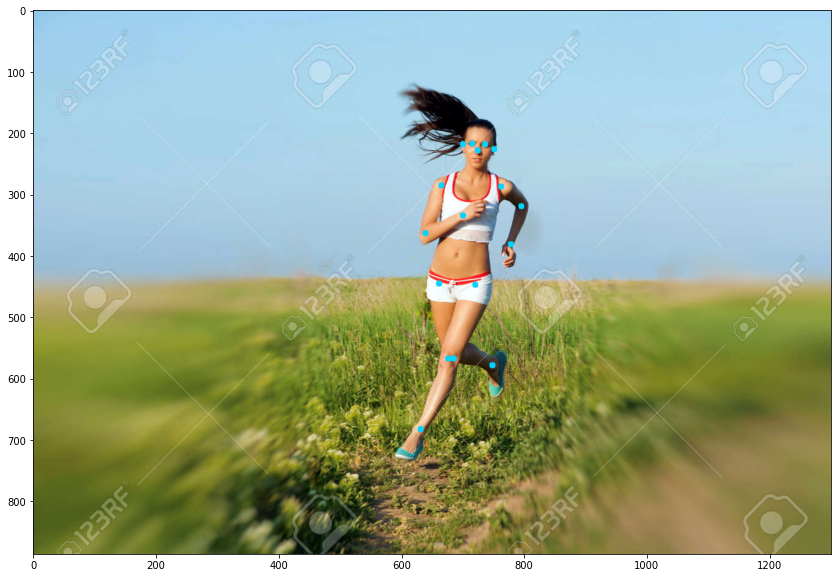

In [4]:
# Model predictions to numpy arrays
boxes, labels, confs, all_keypoints,  all_scores = (
    [x.cpu().numpy() for x in predictions[0].values()])

im_keypoints = draw_keypoints_per_person(
    image, all_keypoints, all_scores, confs)

fig = plt.figure(figsize=(16, 10))
plt.imshow(im_keypoints);

Drawing joints

In [5]:
def get_joints_from_keypoints(keypoints):
    joints = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return joints


joints = get_joints_from_keypoints(keypoints)

In [6]:
def draw_joints(
    img, joints, all_keypoints, all_scores, confs,
    keypoint_threshold=2, conf_threshold=0.9
):
    # new image copy to return
    img = img.copy()    
    
    # color sequence 
    cmap = plt.get_cmap('jet')
    #color_ids = np.arange(0, 256, 256 // len(all_keypoints)).tolist()[::-1]
    color_ids = (np.linspace(0, 255, len(all_keypoints) + 2)
                 .astype(int).tolist()[1:-1])
    
    # for each instance
    for person_id, conf in enumerate(confs): 
        if conf > conf_threshold:
            keypoints = all_keypoints[person_id, ...]
            scores = all_scores[person_id, ...]
            color = tuple(np.asarray(cmap(color_ids[person_id])[:-1]) * 255)
            
            # for each keepoint
            for kp_id, score in enumerate(scores):
                if score > keypoint_threshold:
                    keypoint = tuple(map(int, keypoints[kp_id, :2]))
                    cv2.circle(img, keypoint, 5, color, -1)
                      
            # for each joint
            for joint in joints:
                kp1_id,  kp2_id = joint[0], joint[1]
                if (scores[kp1_id] > keypoint_threshold 
                    and  scores[kp2_id] > keypoint_threshold
                ):
                    keypoint1 = tuple(map(int, keypoints[kp1_id, :2]))
                    keypoint2 = tuple(map(int, keypoints[kp2_id, :2]))
                    cv2.line(img, keypoint1, keypoint2, color, thickness=2)
    
    return img

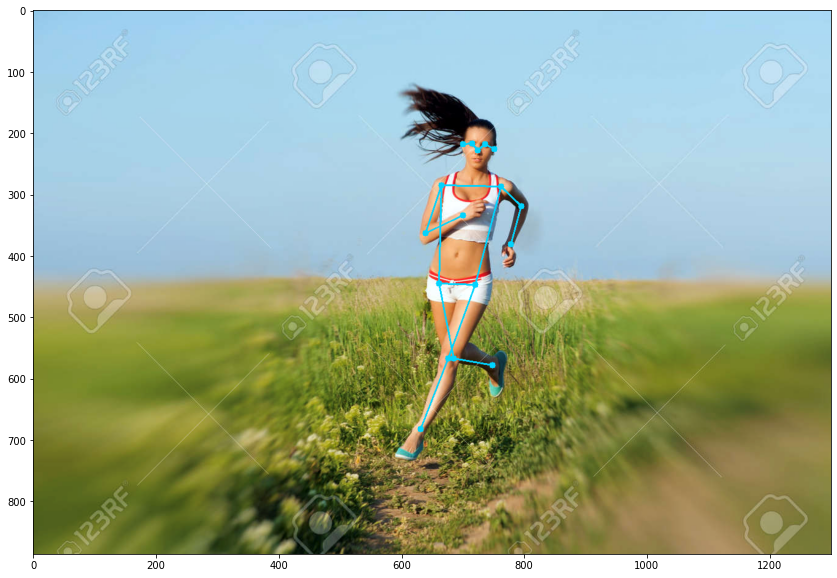

In [7]:
im_joints = draw_joints(
    image, joints, all_keypoints, all_scores, confs)

fig = plt.figure(figsize=(16, 10))
plt.imshow(im_joints);